# Importing Libraries

In [1]:
import argparse
import concurrent.futures
import csv
import time
from pathlib import Path
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Add, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.spatial.distance import mahalanobis
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
import os


# Download Valid Images

In [2]:
def download_image(url):
    filename = url.split("/")[-1]
    file = Path("./images").joinpath(filename)
    file.parent.mkdir(parents=True, exist_ok=True)
    try:
        with file.open("wb") as handle:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            for block in response.iter_content(1024):
                if not block:
                    break
                handle.write(block)
        return file
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")
        return None

def is_valid_image(file_path):
    try:
        img = tf.io.read_file(str(file_path))
        img = tf.image.decode_image(img, channels=3)
        return True
    except:
        return False

def process_image(data):
    url, filename = data
    file_path = download_image(url)
    if file_path and is_valid_image(file_path):
        return (str(file_path), url)
    return None

# Parse arguments for CSV file
parser = argparse.ArgumentParser()
parser.add_argument("--csv_file", help="CSV file with image URLs")
args = parser.parse_args(args=["--csv_file", "/Users/namansinghnegi/Downloads/images.csv"])

# Read image URLs from CSV file
with open(args.csv_file, "r") as handle:
    reader = csv.DictReader(handle, delimiter=';')
    image_data = [(row['url'], row['url'].split("/")[-1]) for row in reader] 

t = time.perf_counter()

valid_images = []
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    results = executor.map(process_image, image_data)
    for result in results:
        if result is not None:
            valid_images.append(result)

image_paths, image_urls = zip(*valid_images)
image_paths, image_urls = list(image_paths), list(image_urls)

print(f"Downloaded and validated {len(image_paths)} images in {time.perf_counter() - t:.2f} seconds")


Failed to download https://farm1.staticflickr.com/5011/5537502948_503ea812fb_o.jpg: 410 Client Error: Gone for url: https://farm1.staticflickr.com/5011/5537502948_503ea812fb_o.jpg
Failed to download https://farm4.staticflickr.com/177/406453588_b2541371b8_o.jpg: 410 Client Error: Gone for url: https://farm4.staticflickr.com/177/406453588_b2541371b8_o.jpg
Failed to download https://c7.staticflickr.com/9/8291/7805590320_6a55e048c2_o.jpg: 404 Client Error: Not Found for url: https://c7.staticflickr.com/9/8291/7805590320_6a55e048c2_o.jpg
Downloaded and validated 292 images in 195.56 seconds


# Plot images

In [3]:
def plot_images(directory, num_images=5, resize_to=(224, 224)):
    path = Path(directory)
    images = list(path.glob('*'))  # Adjust the pattern if different image formats are used
    print(f"Found {len(images)} images")  # Debug: Print how many images were found

    if len(images) < num_images:
        num_images = len(images)  # Adjust to plot only the available number of images if less than requested

    plt.figure(figsize=(20, 10))  # Adjust the figure size as necessary

    for i, img_path in enumerate(images[:num_images]):
        img = Image.open(img_path)
        img = img.resize(resize_to,Image.LANCZOS)  # Resize the image
        plt.subplot(1, num_images, i + 1)  # Adjust subplot dimensions for the number of images
        plt.imshow(img)
        plt.axis('off')

    plt.show()

Found 295 images


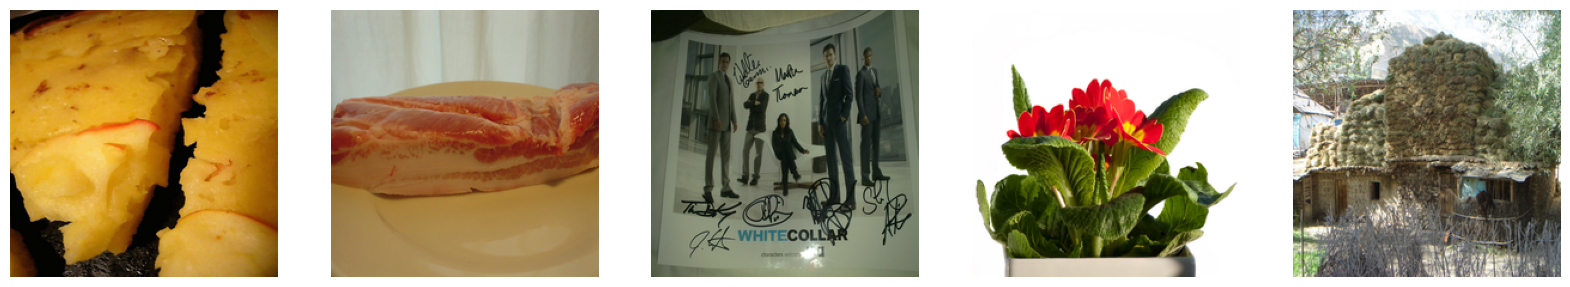

In [4]:
plot_images("images", num_images=5, resize_to=(224, 224))

# Define the Machine Learning Model

### I selected the ReseNet50 model as the base model

In [5]:
# I selected the ReseNet50 model as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Get features from ResNet50 model
encoder_output = base_model.output

### I then use the Autoencoder architecture to re tune the model for this case study

In [6]:
# Decoder
x = Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(encoder_output)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(16, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
decoded_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create autoencoder model
autoencoder = Model(inputs=base_model.input, outputs=decoded_output)

# Compile the autoencoder model with MSE loss
autoencoder.compile(optimizer='adam', loss='mse')

# Print autoencoder summary
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Create Training and Validation Datsets

In [7]:
# Constants
image_size = (224, 224)  # Size of your input images
batch_size = 32  # Batch size for training
split_ratio = 0.8  # Ratio of training to validation data

combined = list(zip(image_paths, image_urls))
np.random.shuffle(combined)
image_paths, image_urls = map(list, zip(*combined))

split_index = int(len(image_paths) * split_ratio)

# Split into training and validation files
train_files = image_paths[:split_index]
val_files = image_paths[split_index:]

# Function to load and preprocess images with augmentation for training
def load_and_augment(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, image_size)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.cast(img, tf.float32) / 255.0
    return img, img  # Autoencoder setup

# Function to load and preprocess images without augmentation for validation
def load_and_preprocess(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, img  # Autoencoder setup

# Create datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for batch in train_dataset.take(1):
    print("Shape of batch of images with augmentation:", batch[0].shape)
for batch in val_dataset.take(1):
    print("Shape of batch of images without augmentation:", batch[0].shape)

2024-07-03 22:20:30.917808: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Shape of batch of images with augmentation: (32, 224, 224, 3)
Shape of batch of images without augmentation: (32, 224, 224, 3)


# Train the Model

In [8]:
history = autoencoder.fit(train_dataset, epochs=200, validation_data=val_dataset)

Epoch 1/200
8/8 [==============================] - 17s 2s/step - loss: 0.1070 - val_loss: 0.1556
Epoch 2/200
8/8 [==============================] - 14s 2s/step - loss: 0.0922 - val_loss: 0.1829
Epoch 3/200
8/8 [==============================] - 14s 2s/step - loss: 0.0914 - val_loss: 0.1725
Epoch 4/200
8/8 [==============================] - 14s 2s/step - loss: 0.0892 - val_loss: 0.1587
Epoch 5/200
8/8 [==============================] - 14s 2s/step - loss: 0.0880 - val_loss: 0.1448
Epoch 6/200
8/8 [==============================] - 14s 2s/step - loss: 0.0859 - val_loss: 0.1381
Epoch 7/200
8/8 [==============================] - 14s 2s/step - loss: 0.0857 - val_loss: 0.1203
Epoch 8/200
8/8 [==============================] - 14s 2s/step - loss: 0.0846 - val_loss: 0.1323
Epoch 9/200
8/8 [==============================] - 14s 2s/step - loss: 0.0829 - val_loss: 0.1199
Epoch 10/200
8/8 [==============================] - 14s 2s/step - loss: 0.0815 - val_loss: 0.1098
Epoch 11/200
8/8 [===========

# Extract encoder model from the autoencoder

In [9]:
encoder_model = Model(inputs=autoencoder.input, outputs=base_model.output)
encoder_model.compile(optimizer='adam', loss='mse')
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# Extract features from the image dataset using the encoder model

In [10]:
def extract_features(img_path, model, target_size=(224, 224)):
    try:
        # Read and preprocess image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = preprocess_input(img)  # Preprocess input to match ResNet50 expectations
        
        # Expand dimensions to match model input
        img = tf.expand_dims(img, axis=0)  # Shape: (1, height, width, channels)
        
        # Extract features using the model
        features = model.predict(img)
        
        return features.flatten()
    except tf.errors.InvalidArgumentError:
        print(f"Warning: Could not process image {img_path}. Skipping.")
        return None

In [11]:
features = []
valid_image_paths = []
valid_image_urls = []
for img_path, img_url in zip(image_paths, image_urls):
    feature = extract_features(img_path, encoder_model)  # Ensure encoder_model is defined
    if feature is not None:
        features.append(feature)
        valid_image_paths.append(img_path)
        valid_image_urls.append(img_url)
features = np.array(features)

1/1 [==============================] - 0s 66ms/step


# Normalize the features and use PCA for dimension reduction

In [12]:
# Normalize features
features = normalize(features, axis=1)

# Dimension Reduction with PCA
n_components = min(features.shape[0], features.shape[1]) - 1
pca = PCA(n_components=n_components)
features = pca.fit_transform(features)

# Use KMeans to cluster the Images

In [26]:
# Cluster the images
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features.astype(np.float32))

# Save the trained model and other artefacts

In [27]:
dump(pca, 'pca_model.joblib')
dump(kmeans, 'kmeans_model.joblib')

# Save the features and labels
encoder_model.save('fine_tuned_resnet_model.h5')
np.save('features.npy', features)
np.save('labels.npy', labels)
np.save('image_paths.npy',valid_image_paths)
np.save('image_urls.npy',valid_image_urls)

# Calculate similarity between images

In [14]:
def calculate_similarity(input_features, dataset_features, top_n=3, metric='cosine'):
    """
    Calculate the similarity between input features and dataset features, and return the top N similar items.
    
    Parameters:
    - input_features: Feature vector of the input image.
    - dataset_features: Feature matrix of the dataset images.
    - top_n: Number of top similar items to return.
    - metric: Similarity metric to use ('cosine' or 'euclidean').
    
    Returns:
    - Indices of the top N similar items in the dataset.
    """
    if len(input_features.shape) == 1:
        input_features = input_features.reshape(1, -1)
    
    if metric == 'cosine':
        similarity_scores = cosine_similarity(input_features, dataset_features)
        indices = np.argsort(similarity_scores[0])[::-1]
    elif metric == 'euclidean':
        similarity_scores = euclidean_distances(input_features, dataset_features)
        indices = np.argsort(similarity_scores[0])
    else:
        raise ValueError("Unsupported metric: {}. Choose 'cosine' or 'euclidean'.".format(metric))
    
    return indices[1:top_n+1]

# Find Similar Images

In [15]:
def download_image_from_url(url, target_path):
    """Download image from URL and save it to target path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(target_path, 'wb') as handle:
            for block in response.iter_content(1024):
                if not block:
                    break
                handle.write(block)
        return target_path
    except requests.exceptions.RequestException as e:
        print("Failed to download {}: {}".format(url, e))
        return None

def display_similar_images(input_image_url, image_paths,image_urls, features, labels, model, pca, kmeans, top_n=3, target_size=(224, 224),metric = 'cosine'):
    
    
        # Download the input image from URL
    input_image_path = download_image_from_url(input_image_url, "input_image.jpg")
    
    if not input_image_path:
        print("Failed to download the input image.")
        return

    
    input_features = extract_features(input_image_path, model)
    input_features= normalize(input_features.reshape(1, -1))
    input_features = pca.transform(input_features)  # Encode input features
    
    # Find the cluster of the input image
    cluster_label = kmeans.predict(input_features)[0]
    
    # Get the indices of images in the same cluster
    cluster_indices = np.where(labels == cluster_label)[0]
    
    # Get the features of images in the same cluster
    cluster_features = features[cluster_indices]
    cluster_image_paths = np.array(image_paths)[cluster_indices]
    cluster_image_urls = np.array(image_urls)[cluster_indices]
    
    # Calculate similarity
    similar_indices = calculate_similarity(input_features, cluster_features, top_n=top_n)
    
    # Display the input image and the most similar images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_n + 1, 1)
    img = Image.open(input_image_path).resize(target_size, Image.LANCZOS)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')
    
    # Verify and display similar images
    for i, idx in enumerate(similar_indices):
        similar_image_path = cluster_image_paths[idx]
        similar_image_url = cluster_image_urls[idx]
        
        print(f"Similar Image {i + 1}:")
        print(f"Path: {similar_image_path}")
        print(f"URL: {similar_image_url}")
        
        plt.subplot(1, top_n + 1, i + 2)
        img = Image.open(similar_image_path).resize(target_size, Image.LANCZOS)
        plt.imshow(img)
        plt.title(f"Similar Image {i + 1}")
        plt.axis('off')
    
    plt.show()

1/1 [==============================] - 0s 93ms/step
Similar Image 1:
Path: images/3290610375_81b71f20de_o.jpg
URL: https://farm6.staticflickr.com/3189/3290610375_81b71f20de_o.jpg
Similar Image 2:
Path: images/5035520687_6616c4d3b4_o.jpg
URL: https://farm4.staticflickr.com/4108/5035520687_6616c4d3b4_o.jpg
Similar Image 3:
Path: images/36148738_960efefc77_o.jpg
URL: https://farm7.staticflickr.com/32/36148738_960efefc77_o.jpg


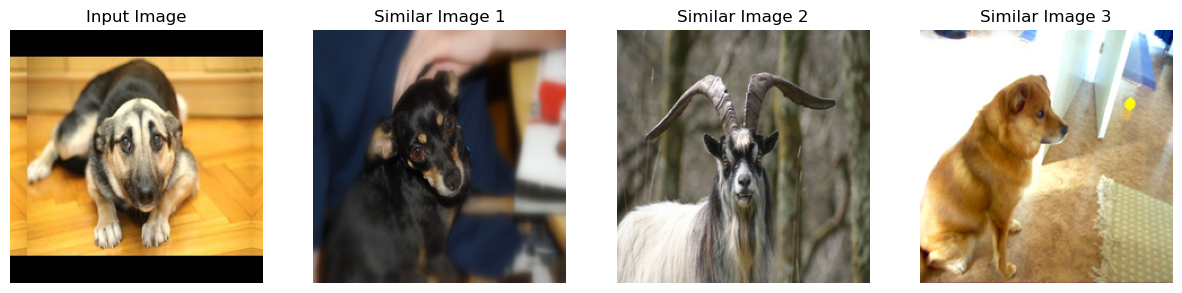

In [25]:
input_image_url = 'https://i.ytimg.com/vi/4OLJe8iMLg4/hqdefault.jpg'  # Update with the path to your input image
display_similar_images(input_image_url, valid_image_paths,valid_image_urls, features, labels, encoder_model, pca, kmeans, top_n=3, metric='cosine')